In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import fasttext

from torch.nn.utils.rnn import pad_sequence
import copy
import numpy as np
from sklearn.metrics import f1_score

from typing_extensions import Literal

In [2]:
"""
CONFIG
"""

input_dir = '/kaggle/input'
glove_840b_path = f'{input_dir}/glove840b300dtxt/glove.840B.300d.txt'
glove_6b_path = f'{input_dir}/glove6b300dtxt/glove.6B.300d.txt'
fasttext_path = f'{input_dir}/fasttext-en-download/cc.en.300.bin'
data_path = f'{input_dir}/col772-a2-data'

lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class BioNERDataset(Dataset):
    
    def __init__(self, filename, label2id):
        
        self.sentences = []
        self.token_counts = 0
        self.class_counts = torch.zeros(len(label2id))
        with open(filename, 'r') as f:
            sentence = []
            for l in f:
                if l == '\n':
                    self.sentences.append(list(zip(*sentence)))
                    sentence = []
                else:
                    token, cls = l.strip().split('\t')
                    sentence.append((token, label2id[cls]))
                    self.class_counts[label2id[cls]] += 1
                    self.token_counts += 1
        
        self.sentences.append(list(zip(*sentence)))
        self.weights = self.token_counts / (self.class_counts*len(label2id))
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        return self.sentences[idx]

def dl_collate_fn(data):
    return tuple(zip(*data))

In [4]:
class GloveModel(nn.Module):
    
    # GloVE vectors are (stupidly) distributed in a textfile... Takes a few minutes to just load them
    def __init__(self, filepath):
        super().__init__()
        # https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
        self.emb_dict = {}
        self.embedding = []
        i = 0
        with open(filepath,'r') as f:
            for line in f:
#                 if (DEBUG and i > 1000):
#                     break
                # split_line = line.split()
                # https://forum.opennmt.net/t/how-to-use-glove-pre-trained-embeddings-in-opennmt-py/1011/18
                split_line = line.strip().split(' ')
                word = split_line[0]
                try:
                    embedding = torch.tensor(np.array(split_line[1:], dtype=np.float32))
                    if (embedding.shape[0] != 300):
                        raise ValueError('could not read embedding')
                    self.embedding.append(embedding)
                    self.emb_dict[word] = i
                    i += 1
                except ValueError as e:
                    print(f'ignoring embedding {split_line[0]}')
                    
        # https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g-glove-6b-50d-txt
        # if you know a cleaner way to format a 300-element vector,
        # kindly let me know
        unk = torch.tensor([0.22418134, -0.28881392, 0.13854356, 0.00365387, 
                    -0.12870757, 0.10243822, 0.061626635, 0.07318011, 
                    -0.061350107, -1.3477012, 0.42037755, -0.063593924, 
                    -0.09683349, 0.18086134, 0.23704372, 0.014126852, 
                    0.170096, -1.1491593, 0.31497982, 0.06622181, 
                    0.024687296, 0.076693475, 0.13851812, 0.021302193, 
                    -0.06640582, -0.010336159, 0.13523154, -0.042144544, 
                    -0.11938788, 0.006948221, 0.13333307, -0.18276379, 
                    0.052385733, 0.008943111, -0.23957317, 0.08500333, 
                    -0.006894406, 0.0015864656, 0.063391194, 0.19177166, 
                    -0.13113557, -0.11295479, -0.14276934, 0.03413971, 
                    -0.034278486, -0.051366422, 0.18891625, -0.16673574, 
                    -0.057783455, 0.036823478, 0.08078679, 0.022949161, 
                    0.033298038, 0.011784158, 0.05643189, -0.042776518, 
                    0.011959623, 0.011552498, -0.0007971594, 0.11300405, 
                    -0.031369694, -0.0061559738, -0.009043574, -0.415336, 
                    -0.18870236, 0.13708843, 0.005911723, -0.113035575, 
                    -0.030096142, -0.23908928, -0.05354085, -0.044904727, 
                    -0.20228513, 0.0065645403, -0.09578946, -0.07391877, 
                    -0.06487607, 0.111740574, -0.048649278, -0.16565254, 
                    -0.052037314, -0.078968436, 0.13684988, 0.0757494, 
                    -0.006275573, 0.28693774, 0.52017444, -0.0877165, 
                    -0.33010918, -0.1359622, 0.114895485, -0.09744406, 
                    0.06269521, 0.12118575, -0.08026362, 0.35256687, 
                    -0.060017522, -0.04889904, -0.06828978, 0.088740796, 
                    0.003964443, -0.0766291, 0.1263925, 0.07809314, 
                    -0.023164088, -0.5680669, -0.037892066, -0.1350967, 
                    -0.11351585, -0.111434504, -0.0905027, 0.25174105, 
                    -0.14841858, 0.034635577, -0.07334565, 0.06320108, 
                    -0.038343467, -0.05413284, 0.042197507, -0.090380974, 
                    -0.070528865, -0.009174437, 0.009069661, 0.1405178, 
                    0.02958134, -0.036431845, -0.08625681, 0.042951006, 
                    0.08230793, 0.0903314, -0.12279937, -0.013899368, 
                    0.048119213, 0.08678239, -0.14450377, -0.04424887, 
                    0.018319942, 0.015026873, -0.100526, 0.06021201, 
                    0.74059093, -0.0016333034, -0.24960588, -0.023739101, 
                    0.016396184, 0.11928964, 0.13950661, -0.031624354, 
                    -0.01645025, 0.14079992, -0.0002824564, -0.08052984, 
                    -0.0021310581, -0.025350995, 0.086938225, 0.14308536, 
                    0.17146006, -0.13943303, 0.048792403, 0.09274929, 
                    -0.053167373, 0.031103406, 0.012354865, 0.21057427, 
                    0.32618305, 0.18015954, -0.15881181, 0.15322933, 
                    -0.22558987, -0.04200665, 0.0084689725, 0.038156632, 
                    0.15188617, 0.13274793, 0.113756925, -0.095273495, 
                    -0.049490947, -0.10265804, -0.27064866, -0.034567792, 
                    -0.018810693, -0.0010360252, 0.10340131, 0.13883452, 
                    0.21131058, -0.01981019, 0.1833468, -0.10751636, 
                    -0.03128868, 0.02518242, 0.23232952, 0.042052146, 
                    0.11731903, -0.15506615, 0.0063580726, -0.15429358, 
                    0.1511722, 0.12745973, 0.2576985, -0.25486213, 
                    -0.0709463, 0.17983761, 0.054027, -0.09884228, 
                    -0.24595179, -0.093028545, -0.028203879, 0.094398156, 
                    0.09233813, 0.029291354, 0.13110267, 0.15682974, 
                    -0.016919162, 0.23927948, -0.1343307, -0.22422817, 
                    0.14634751, -0.064993896, 0.4703685, -0.027190214, 
                    0.06224946, -0.091360025, 0.21490277, -0.19562101, 
                    -0.10032754, -0.09056772, -0.06203493, -0.18876675, 
                    -0.10963594, -0.27734384, 0.12616494, -0.02217992, 
                    -0.16058226, -0.080475815, 0.026953284, 0.110732645, 
                    0.014894041, 0.09416802, 0.14299914, -0.1594008, 
                    -0.066080004, -0.007995227, -0.11668856, -0.13081996, 
                    -0.09237365, 0.14741232, 0.09180138, 0.081735, 
                    0.3211204, -0.0036552632, -0.047030564, -0.02311798, 
                    0.048961394, 0.08669574, -0.06766279, -0.50028914, 
                    -0.048515294, 0.14144728, -0.032994404, -0.11954345, 
                    -0.14929578, -0.2388355, -0.019883996, -0.15917352, 
                    -0.052084364, 0.2801028, -0.0029121689, -0.054581646, 
                    -0.47385484, 0.17112483, -0.12066923, -0.042173345, 
                    0.1395337, 0.26115036, 0.012869649, 0.009291686, 
                    -0.0026459037, -0.075331464, 0.017840583, -0.26869613, 
                    -0.21820338, -0.17084768, -0.1022808, -0.055290595, 
                    0.13513643, 0.12362477, -0.10980586, 0.13980341, 
                    -0.20233242, 0.08813751, 0.3849736, -0.10653763, 
                    -0.06199595, 0.028849555, 0.03230154, 0.023856193, 
                    0.069950655, 0.19310954, -0.077677034, -0.144811])
    
        self.embedding.append(unk)
        self.unk_index = i
        self.embedding = nn.Embedding.from_pretrained(torch.vstack(self.embedding))
    
    def forward(self, sentence):
        sentence = torch.tensor([self.emb_dict[word.lower()] if word.lower() in self.emb_dict else self.unk_index for word in sentence], device=device)
        return self.embedding(sentence)

In [5]:
class LSTMByteEmbeddingModel(nn.Module):
    
    def __init__(self, emb_dim=50):
        super().__init__()
        self.char_embeds  = nn.Embedding(256,emb_dim)
        self.lstm = nn.LSTM(
                input_size=50,
                batch_first=True, 
                hidden_size=50, 
                bidirectional=True,
            )
        self.h0 = nn.Parameter(torch.randn(2,emb_dim))
        self.c0 = nn.Parameter(torch.randn(2,emb_dim))
    
    def forward(self, sentence):
        
        x = pad_sequence([torch.tensor(bytearray(w.encode('utf-8'))).to(device) for w in sentence], batch_first=True)
        x = self.char_embeds(x)
        
        batch_size = len(sentence)
        h0 = torch.stack([self.h0 for _ in range(batch_size)], dim=1)
        c0 = torch.stack([self.c0 for _ in range(batch_size)], dim=1)
        _, (h, c) = self.lstm(x, (h0, c0))
        return torch.cat((c[0], c[1]), 1)

In [6]:
class GRUByteEmbeddingModel(nn.Module):
    
    def __init__(self, emb_dim=50):
        super().__init__()
        self.char_embeds  = nn.Embedding(256,emb_dim)
        self.gru = nn.GRU(
                input_size=50,
                batch_first=True, 
                hidden_size=50, 
                bidirectional=True,
            )
        self.h0 = nn.Parameter(torch.randn(2,emb_dim))
    
    def forward(self, sentence):
        
        x = pad_sequence([torch.tensor(bytearray(w.encode('utf-8'))).to(device) for w in sentence], batch_first=True)
        x = self.char_embeds(x)
        
        batch_size = len(sentence)
        h0 = torch.stack([self.h0 for _ in range(batch_size)], dim=1)
        _, h = self.gru(x, h0)
        return torch.cat((h[0], h[1]), 1)

In [7]:
class EmbeddingModel(nn.Module):

    # Embedding: 400
    #  - Pretrained: 300
    #  - Character: 100
    #    - L: 50
    #    - R: 50
    #
    # Tentative:
    #  - POS: 25
    #  - Chunk: 10
    #  - Dict:  5 (may not be allowed)
    def __init__(self, emb_model_path, 
                 emb_type:Literal['glove', 'fasttext'] = 'fasttext', 
                 byte_emb_type:Literal['lstm', 'gru'] = 'lstm'):
        super().__init__()

        self.emb_type = emb_type
        
        if byte_emb_type == 'lstm':
            self.byte_emb_model = LSTMByteEmbeddingModel()
        else:
            self.byte_emb_model = GRUByteEmbeddingModel()
            
        if emb_type == 'fasttext':
            self.word_emb_model = fasttext.load_model(emb_model_path)
        else:
            self.word_emb_model = GloveModel(emb_model_path)
            
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, sentence):
        if self.emb_type == 'fasttext':
            word_emb = torch.tensor(np.array([self.word_emb_model.get_word_vector(w) for w in sentence]), requires_grad=False).to(device)
        else:
            word_emb = self.word_emb_model(sentence)
        byte_emb = self.byte_emb_model(sentence)
        
        return self.dropout(torch.cat([word_emb, byte_emb], 1))

In [8]:
class ProjectiveAttention(nn.Module):
    
    def __init__(self, emb_dim = 800):
        super().__init__()
        self.W = nn.Parameter(torch.zeros((emb_dim, emb_dim)))
        self.dropout = nn.Dropout(p=0.2)
        nn.init.normal_(self.W.data, 0, 0.1)
        
    def forward(self, h):
        # h: (B, N, K)
        
        # att = softmax(h@W@h_T, axis=1) @ h, across all batches
        att = torch.bmm(
                F.softmax(
                    torch.bmm(
                        h, 
                        torch.bmm(
                            self.W.unsqueeze(0).expand([h.size(0),-1,-1]), 
                            h.transpose(2,1)
                        )
                    ), dim=2), 
                h
              )
        return self.dropout(att)

class PostAttentionLayer(nn.Module):
    
    def __init__(self, emb_dim = 1600, proj_dim = 800):
        super().__init__()
        self.fwd = nn.Linear(emb_dim, proj_dim, bias=False)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, g, h):
        return self.dropout(torch.tanh(self.fwd(torch.cat([g,h], dim=2))))

In [9]:
class BiLSTMNERTagger(nn.Module):

    def __init__(self, num_layers=2, embedding_size=400):
        super().__init__()

        self.num_layers = num_layers
        self.lstm = nn.LSTM(
                input_size=embedding_size, 
                batch_first=True, 
                hidden_size=embedding_size, 
                bidirectional=True,
                num_layers=self.num_layers,
                dropout=0.2
            )
        self.pa = ProjectiveAttention(emb_dim=embedding_size*2)
        self.pal = PostAttentionLayer(emb_dim=embedding_size*4, proj_dim = embedding_size*2)
        self.clf = nn.Linear(2*embedding_size, 13)
        self.lstm_final_dropout = nn.Dropout(p=0.2)

        # TODO better initialization for this (closer to 0)
        self.h0 = nn.Parameter(torch.zeros(2*self.num_layers,embedding_size))
        self.c0 = nn.Parameter(torch.zeros(2*self.num_layers,embedding_size))
        nn.init.normal_(self.h0.data, 0, 0.1)
        nn.init.normal_(self.c0.data, 0, 0.1)
        
    def forward(self, x):

        batch_size = x.size(0)
        h = torch.stack([self.h0 for _ in range(batch_size)], dim=1)
        c = torch.stack([self.c0 for _ in range(batch_size)], dim=1)
        lstm_output, _ = self.lstm(x, (h,c))
        lstm_dropout_output = self.lstm_final_dropout(lstm_output)
        logits = self.clf(self.pal(lstm_dropout_output, self.pa(lstm_dropout_output)))
        return logits

In [10]:
def preprocess_batch(emb_model, sentences, labels=None):
    
    pt_sents = []
    pt_labels = []
    pt_masks = []
    i = 0
    for i in range(len(sentences)):
        emb = emb_model(sentences[i])
        pt_sents.append(emb)
        if labels:
            pt_labels.append(torch.tensor(labels[i]))
        pt_masks.append(torch.tensor([1]*emb.shape[0]))
        
        i += 1
        
    if labels:
        return pad_sequence(pt_sents, batch_first=True), pad_sequence(pt_labels, batch_first=True, padding_value=-100), (pad_sequence(pt_masks, batch_first=True) > 0)
    
    return pad_sequence(pt_sents, batch_first=True), (pad_sequence(pt_masks, batch_first=True) > 0)
    

In [11]:
label2id = {'O': 0,
 'B-Biological_Molecule': 1,
 'E-Biological_Molecule': 2,
 'S-Biological_Molecule': 3,
 'I-Biological_Molecule': 4,
 'B-Species': 5,
 'E-Species': 6,
 'S-Species': 7,
 'I-Species': 8,
 'B-Chemical_Compound': 9,
 'E-Chemical_Compound': 10,
 'S-Chemical_Compound': 11,
 'I-Chemical_Compound': 12}

## Training

In [12]:
import random
seed = 3143
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [13]:
# train
train_ds = BioNERDataset(f'{data_path}/train.txt', label2id)
val_ds = BioNERDataset(f'{data_path}/dev.txt', label2id)

In [14]:
DEBUG = False
if DEBUG:
    train_ds.sentences = train_ds.sentences[:128]
    val_ds.sentences = val_ds.sentences[:32]

In [15]:
train_dl = DataLoader(train_ds, batch_size=16, collate_fn=dl_collate_fn, num_workers=2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, collate_fn=dl_collate_fn, num_workers=2, shuffle=False)

In [16]:
model = BiLSTMNERTagger(num_layers=2).to(device)

In [17]:
emb_model = EmbeddingModel(glove_6b_path, emb_type='glove').to(device)

In [18]:
optimizer = optim.Adam(list(model.parameters())+list(emb_model.parameters()), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss_fn = nn.CrossEntropyLoss(weight=train_ds.weights.to(device))

In [19]:
best_model = None
best_emb_model = None
f1_means = []
best_val_loss = 10000
best_f1_mean = 0
val_losses = []
train_losses = []
possible_labels = range(1,13)

for epoch in range(30):

    print(f'Epoch {epoch+1}:')
    train_loss = torch.tensor(0, dtype=torch.float, device=device)
    model.train()
    for (sentences, answers) in tqdm(train_dl):
        tokens, labels, masks = preprocess_batch(emb_model, sentences, labels=answers)
        tokens = tokens.to(device)
        labels = labels.to(device).flatten()

        optimizer.zero_grad()
        logits = model(tokens).flatten(end_dim=1)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.detach()
    
    scheduler.step()

    train_loss = train_loss.cpu()
    train_loss /= len(train_dl)
    print(f' Train Loss: {train_loss}')
    train_losses.append(train_loss)

    val_loss = torch.tensor(0, dtype=torch.float, device=device)
    true_labels = []
    pred_labels = []
    model.eval()
    for (sentences, answers) in tqdm(val_dl):
        tokens, labels, mask = preprocess_batch(emb_model, sentences, labels=answers)
        tokens = tokens.to(device)
        labels = labels.to(device).flatten()
        mask = mask.to(device).flatten()

        logits = model(tokens).flatten(end_dim=1)
        loss = loss_fn(logits, labels)

        val_loss += loss.detach()
        
        pred_labels.append(torch.argmax(logits, axis=1)[mask])
        true_labels.append(labels[mask])
    
    val_loss = val_loss.cpu()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)
    
    pred_labels = np.array(torch.hstack(pred_labels).cpu())
    true_labels = np.array(torch.hstack(true_labels).cpu())

    f1_micro = f1_score(true_labels, pred_labels, average="micro", labels=possible_labels)
    f1_macro = f1_score(true_labels, pred_labels, average="macro", labels=possible_labels)

    f1_mean = (f1_macro + f1_micro)/2
    f1_means.append(f1_mean)

    print(f' Val Loss: {val_loss}')
    print(f' F1 micro: {f1_micro}')
    print(f' F1 macro: {f1_macro}')
    print(f' F1 mean: {f1_mean}')
    print('')
    
    # early stopping
    if f1_mean <= best_f1_mean:
        if patience >= 4:
            break
        else:
            patience += 1
    else:
        patience = 0
        best_val_loss = val_loss
        best_f1_mean = f1_mean
        best_model = copy.deepcopy(model)
        best_emb_model = copy.deepcopy(emb_model)

Epoch 1:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.7100588083267212


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.4258972108364105
 F1 micro: 0.4107043614836293
 F1 macro: 0.36230502098882295
 F1 mean: 0.3865046912362261

Epoch 2:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.3595413267612457


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.3364708125591278
 F1 micro: 0.49137047163362946
 F1 macro: 0.45888353607136406
 F1 mean: 0.47512700385249673

Epoch 3:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.25525933504104614


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.3295409381389618
 F1 micro: 0.5181190301249081
 F1 macro: 0.48604198110710567
 F1 mean: 0.5020805056160069

Epoch 4:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.20060138404369354


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.31542229652404785
 F1 micro: 0.5146031332725773
 F1 macro: 0.47840169476451244
 F1 mean: 0.4965024140185449

Epoch 5:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.16234424710273743


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.3482111096382141
 F1 micro: 0.5196157276755033
 F1 macro: 0.4677478222448019
 F1 mean: 0.49368177496015264

Epoch 6:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.14687256515026093


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.3414901793003082
 F1 micro: 0.5412691892220853
 F1 macro: 0.512593287949774
 F1 mean: 0.5269312385859297

Epoch 7:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.1460554599761963


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.3385605216026306
 F1 micro: 0.5670786661516674
 F1 macro: 0.5231539861929898
 F1 mean: 0.5451163261723286

Epoch 8:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.11814208328723907


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.344816654920578
 F1 micro: 0.5618650812227891
 F1 macro: 0.5386347372744131
 F1 mean: 0.5502499092486011

Epoch 9:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.11315249651670456


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.372717022895813
 F1 micro: 0.6036014809828342
 F1 macro: 0.5730845949045531
 F1 mean: 0.5883430379436936

Epoch 10:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.11071739345788956


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.38627544045448303
 F1 micro: 0.5715152289125854
 F1 macro: 0.530981561084482
 F1 mean: 0.5512483949985337

Epoch 11:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.08292511850595474


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.35857319831848145
 F1 micro: 0.6124274496415159
 F1 macro: 0.57830709924015
 F1 mean: 0.5953672744408329

Epoch 12:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.06826873123645782


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.358334481716156
 F1 micro: 0.6249652681300361
 F1 macro: 0.5944049488042032
 F1 mean: 0.6096851084671197

Epoch 13:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.06212247535586357


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.36754366755485535
 F1 micro: 0.6308547700320232
 F1 macro: 0.6003329404109835
 F1 mean: 0.6155938552215033

Epoch 14:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.05862225964665413


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.38604843616485596
 F1 micro: 0.6407582938388625
 F1 macro: 0.6088098841541868
 F1 mean: 0.6247840889965246

Epoch 15:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.0558345653116703


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.38813334703445435
 F1 micro: 0.6515929364645913
 F1 macro: 0.6195900624425268
 F1 mean: 0.635591499453559

Epoch 16:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.05346142128109932


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.41590940952301025
 F1 micro: 0.6529447280311762
 F1 macro: 0.6209060575094506
 F1 mean: 0.6369253927703133

Epoch 17:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.051227301359176636


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.4233264923095703
 F1 micro: 0.6676184393432769
 F1 macro: 0.6315583468712536
 F1 mean: 0.6495883931072652

Epoch 18:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.048727668821811676


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.4221689999103546
 F1 micro: 0.6634844868735084
 F1 macro: 0.6267025055326468
 F1 mean: 0.6450934962030777

Epoch 19:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.046483784914016724


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.4483702778816223
 F1 micro: 0.6759817003431187
 F1 macro: 0.6407089377900906
 F1 mean: 0.6583453190666047

Epoch 20:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.046948228031396866


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.4528754651546478
 F1 micro: 0.6798447825418781
 F1 macro: 0.6427524410874691
 F1 mean: 0.6612986118146735

Epoch 21:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.04350598156452179


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.4696829617023468
 F1 micro: 0.6811929256733327
 F1 macro: 0.6451681544111655
 F1 mean: 0.663180540042249

Epoch 22:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.04369913786649704


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.4789155423641205
 F1 micro: 0.682303349060252
 F1 macro: 0.6469698551017112
 F1 mean: 0.6646366020809816

Epoch 23:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.04356228932738304


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.4795120656490326
 F1 micro: 0.684457546254994
 F1 macro: 0.6472352504887932
 F1 mean: 0.6658463983718936

Epoch 24:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.0433436781167984


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.48221537470817566
 F1 micro: 0.6877972709551656
 F1 macro: 0.6508140061998724
 F1 mean: 0.669305638577519

Epoch 25:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.043116990476846695


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.4909842908382416
 F1 micro: 0.6847214926360434
 F1 macro: 0.6474065301561828
 F1 mean: 0.6660640113961132

Epoch 26:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.04306923598051071


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.48548680543899536
 F1 micro: 0.6867950990513664
 F1 macro: 0.6505554853835706
 F1 mean: 0.6686752922174685

Epoch 27:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.04266688972711563


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.4888521730899811
 F1 micro: 0.6863185001658245
 F1 macro: 0.650718175636187
 F1 mean: 0.6685183379010058

Epoch 28:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.043129418045282364


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.4894297420978546
 F1 micro: 0.6857642600330385
 F1 macro: 0.6490382240557796
 F1 mean: 0.6674012420444091

Epoch 29:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.04244031757116318


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.4937906265258789
 F1 micro: 0.6893647031167355
 F1 macro: 0.6512467636688185
 F1 mean: 0.670305733392777

Epoch 30:


  0%|          | 0/2401 [00:00<?, ?it/s]

 Train Loss: 0.042818132787942886


  0%|          | 0/565 [00:00<?, ?it/s]

 Val Loss: 0.49273642897605896
 F1 micro: 0.6902255933831167
 F1 macro: 0.6522154391160357
 F1 mean: 0.6712205162495762



In [20]:
print(f'Best F1 mean: {best_f1_mean}')

Best F1 mean: 0.6712205162495762


In [21]:
torch.save(best_model, '/kaggle/working/best_model.pt')
torch.save(best_emb_model, '/kaggle/working/best_emb_model.pt')

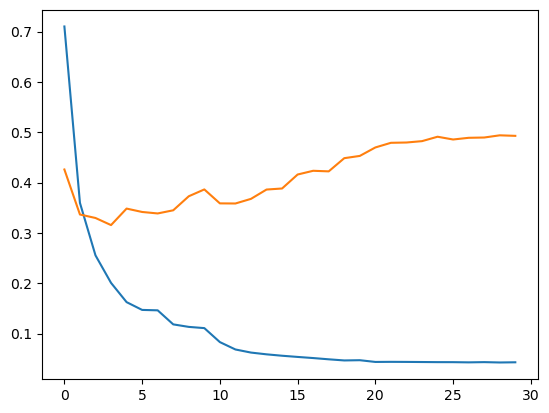

In [22]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)

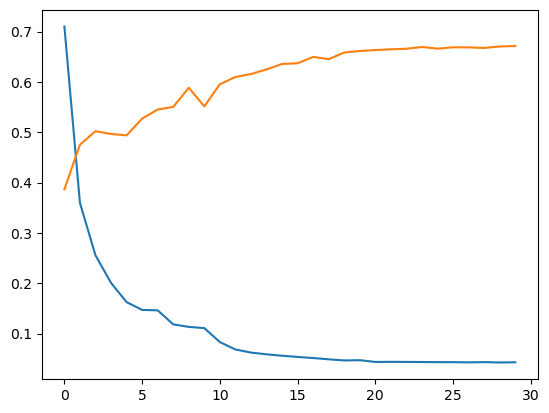

In [23]:
plt.plot(train_losses)
plt.plot(f1_means)